In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score

In [3]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv')


In [4]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
def get_df_info(df):
    print("\n\033[1mShape of DataFrame:\033[0m ", df.shape)
    print("\n\033[1mColumns in DataFrame:\033[0m ", df.columns.to_list())
    print("\n\033[1mData types of columns:\033[0m\n", df.dtypes)
    
    print("\n\033[1mInformation about DataFrame:\033[0m")
    df.info()
    
    print("\n\033[1mNumber of unique values in each column:\033[0m")
    for col in df.columns:
        print(f"\033[1m{col}\033[0m: {df[col].nunique()}")
        
    print("\n\033[1mNumber of null values in each column:\033[0m\n", df.isnull().sum())
    
    print("\n\033[1mNumber of duplicate rows:\033[0m ", df.duplicated().sum())
    
    print("\n\033[1mDescriptive statistics of DataFrame:\033[0m\n", df.describe().transpose())

# Call the function
get_df_info(df)


Shape of DataFrame:  (53043, 3)

Columns in DataFrame:  ['Unnamed: 0', 'statement', 'status']

Data types of columns:
 Unnamed: 0     int64
statement     object
status        object
dtype: object

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB

Number of unique values in each column:
Unnamed: 0: 53043
statement: 51073
status: 7

Number of null values in each column:
 Unnamed: 0      0
statement     362
status          0
dtype: int64

Number of duplicate rows:  0

Descriptive statistics of DataFrame:
               count     mean           std  min      25%      50%      75%  \
Unnamed: 0  53043.0  26521.0  15312.339501  0.0  13260.5  26521.0  39781.5 

In [6]:
df.drop(columns=['Unnamed: 0'], inplace=True)


In [7]:
df.head()


,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [8]:
df.shape


(53043, 2)

In [9]:
df.dropna(inplace=True)


In [10]:
df.shape


(52681, 2)

In [11]:
df['statement'][40000]


'it s been a lot of stress past the last three year i feel like i can t take it anymore i m too anti social i can t talk to anyone i just start shaking and can t say a word and then this feeling of embarrassment will haunt me for the rest of the day no one want to talk with me i feel like i shouldn t be here like i m a burden to everyone i have to hold my emotion inside never letting them out and this is killing me i ve been cry for the last few day i feel so pathetic am i the problem i am so lost'

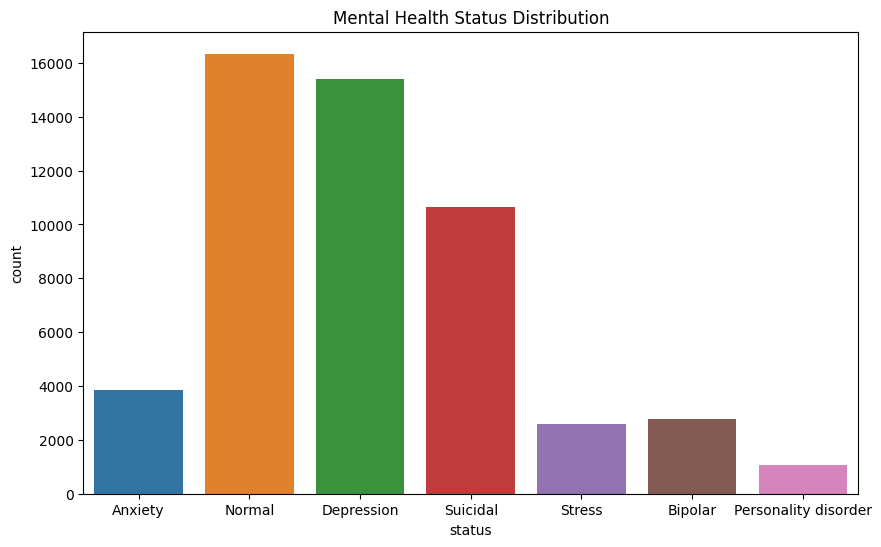

In [12]:

plt.figure(figsize= (10, 6))
plt.title('Mental Health Status Distribution')
sns.countplot(x=df['status'])
plt.show()

In [13]:
df['statement'] = df['statement'].str.lower()


In [14]:
import string
exclude = string.punctuation

def remove_punct(text):
    return text.translate(str.maketrans('', '', exclude))

df['statement'] = df['statement'].apply(remove_punct)

In [15]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return " ".join(filtered_words)

In [16]:
df['statement'] = df['statement'].apply(remove_stopwords)


In [17]:
df['statement'][1106]


'idols world could free bucin like hyuna n hyojong ahhhhh beautifull world gonna'

In [18]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['statement'])
tokens = vectorizer.get_feature_names_out()

In [19]:
# Create a DataFrame with word frequencies
word_freq = pd.DataFrame(X.toarray(), columns=tokens)
word_freq['status'] = df['status']

# Calculate the sum of word frequencies for each label
label_word_freq = word_freq.groupby('status').sum()
label_word_freq.head()

,00,000,0000,00000,000000,000000000,000000062,000001,000002,00001,...,ˆðÿ,α2,α3,ấy,𝗘𝘅𝗰𝗲𝗹𝗹𝗲𝗻𝗰𝗲,𝗛𝗼𝘀𝗽𝗶𝘁𝗮𝗹,𝗠𝗼𝗿𝗮𝗱𝗮𝗯𝗮𝗱,𝗧𝗿𝘂𝘀𝘁,𝗶𝗻,𝗿𝗲𝗴𝗶𝗼𝗻
status,,,,,,,,,,,,,,,,,,,,,
Anxiety,6,0,0,0,0,0,1,1,0,1,...,0,0,0,0,1,1,1,1,1,1
Bipolar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Depression,72,28,0,2,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
Normal,32,7,8,0,2,0,0,0,0,0,...,3,1,4,0,0,0,0,0,0,0
Personality disorder,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


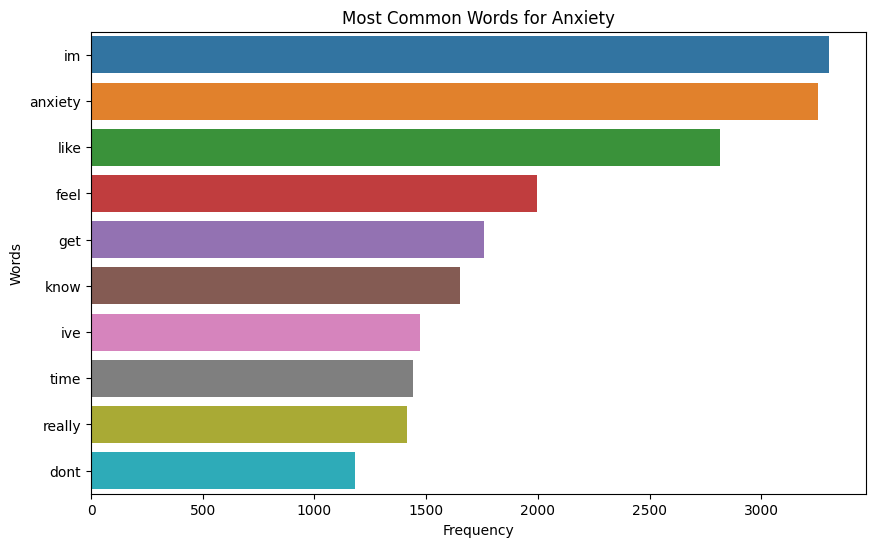

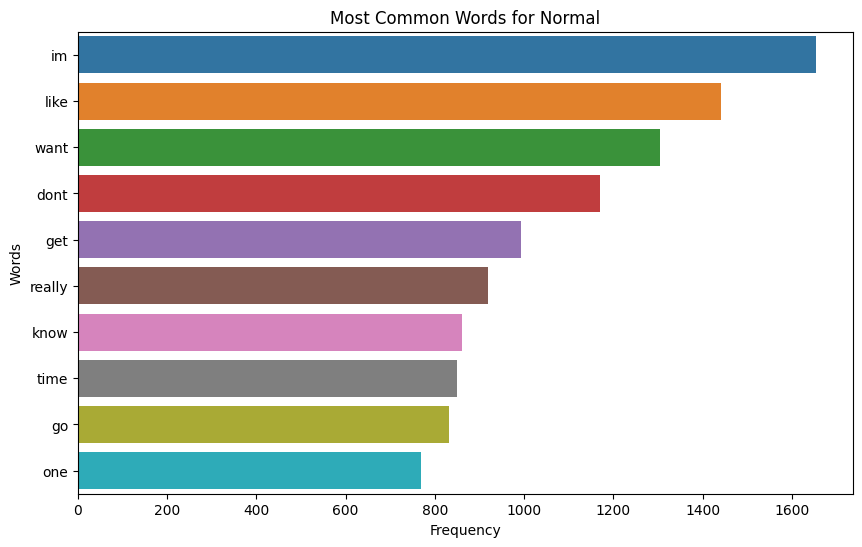

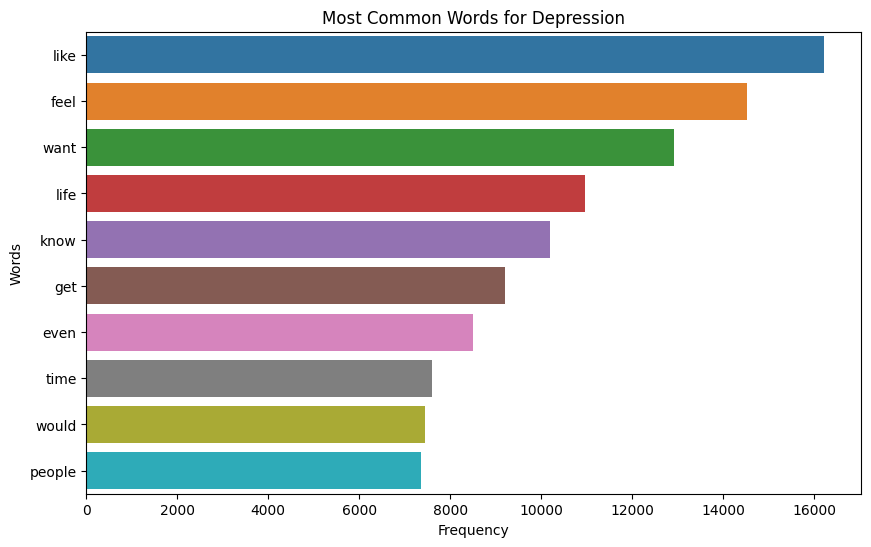

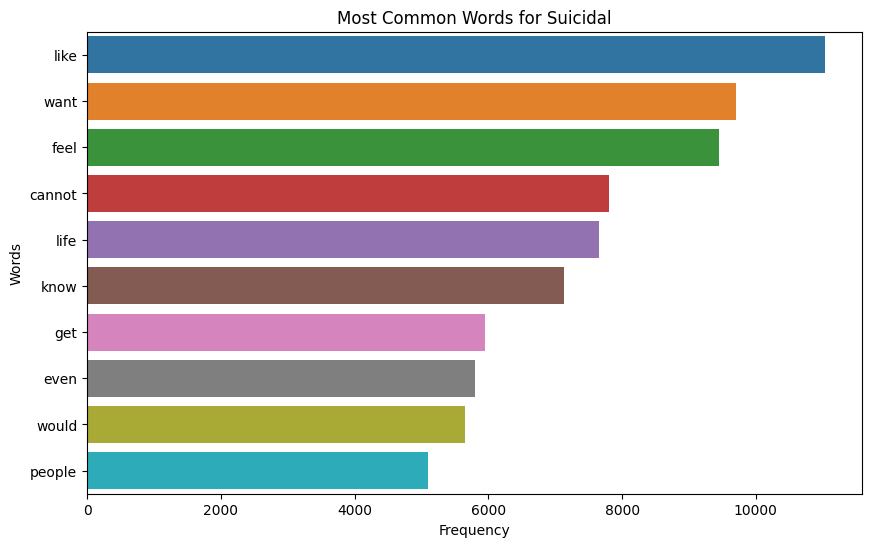

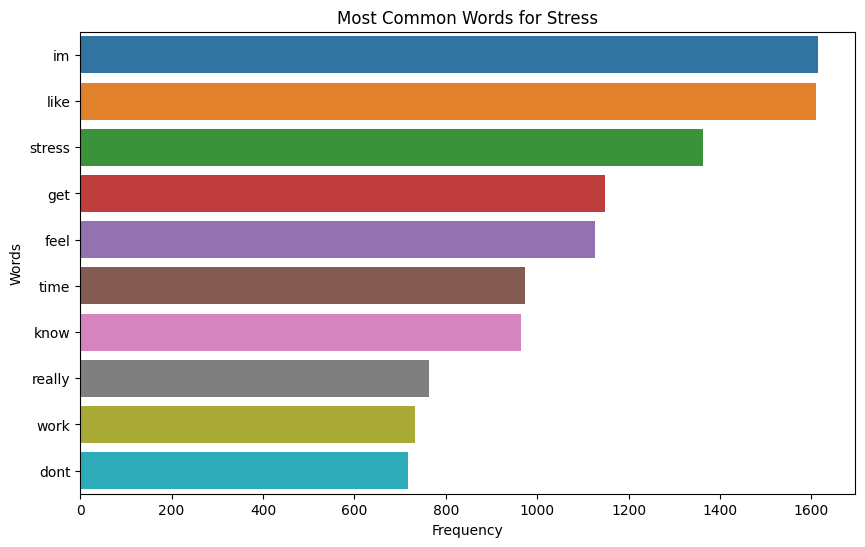

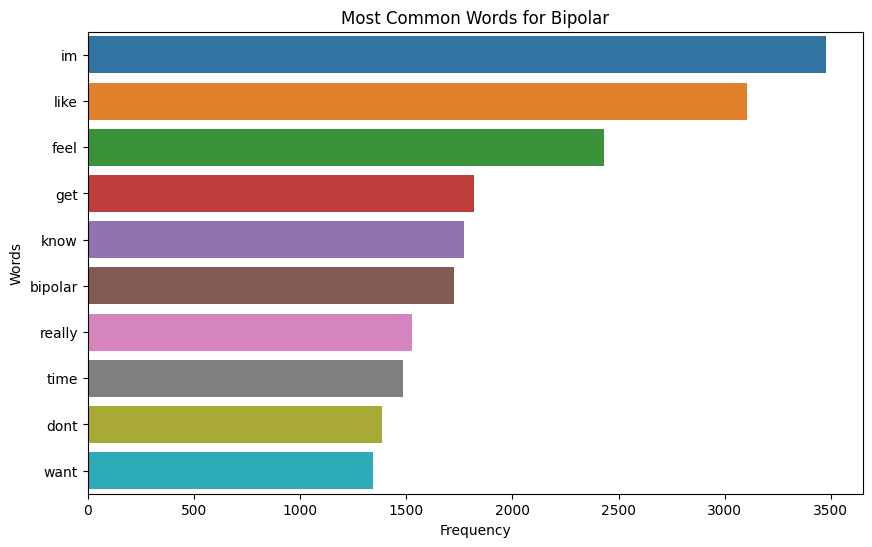

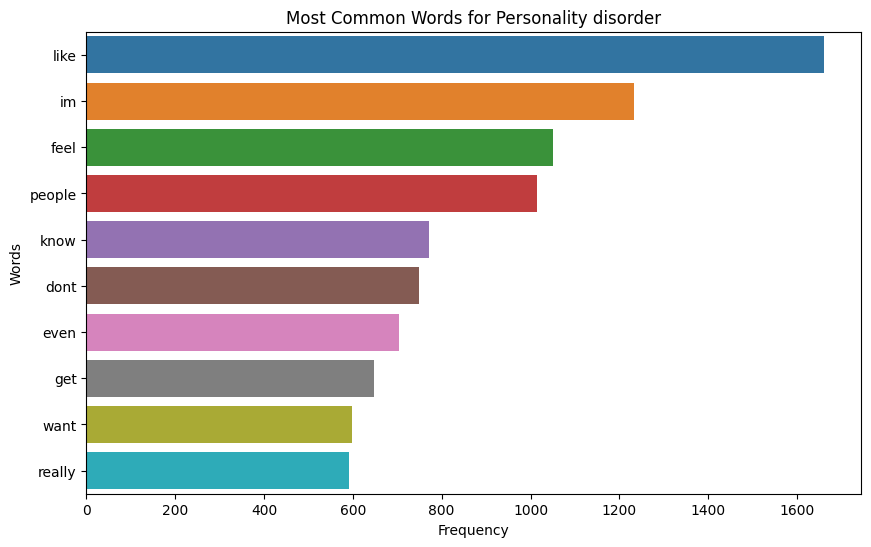

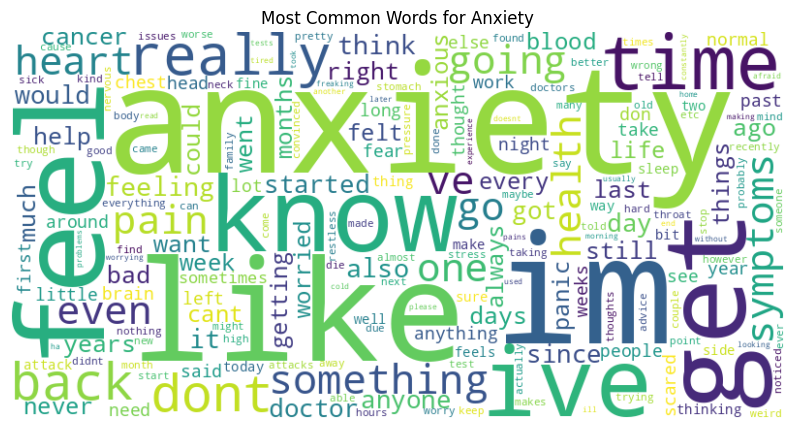

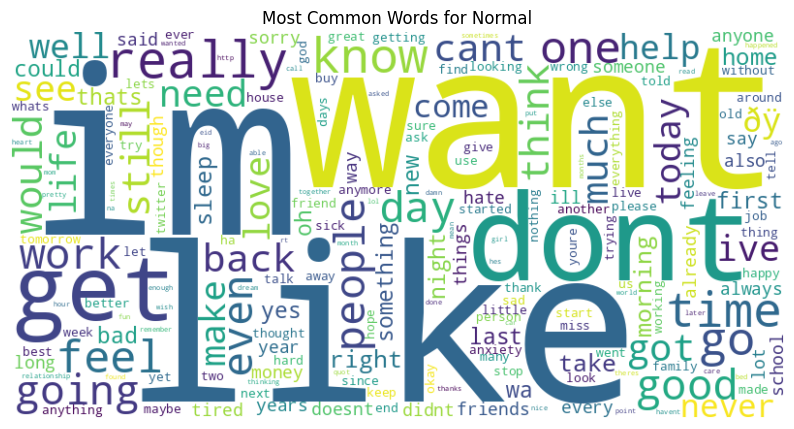

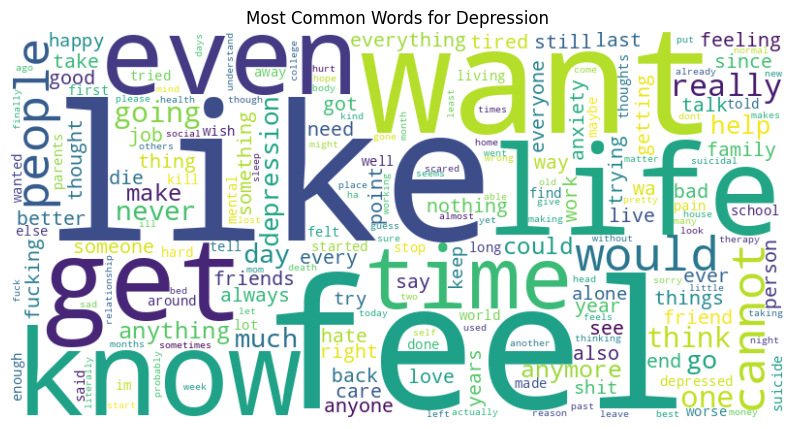

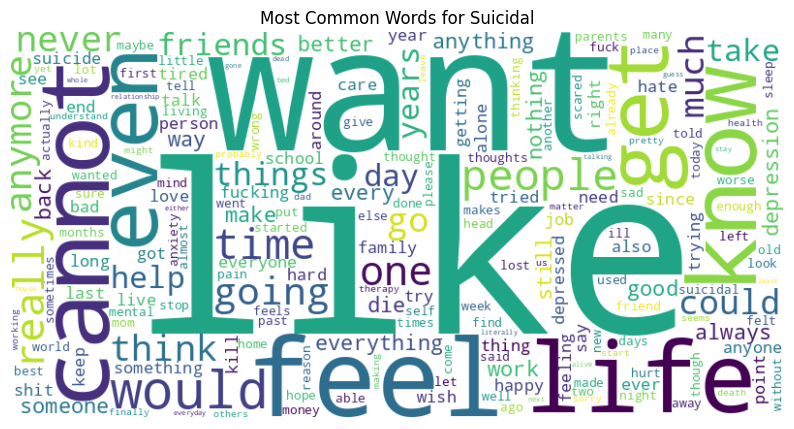

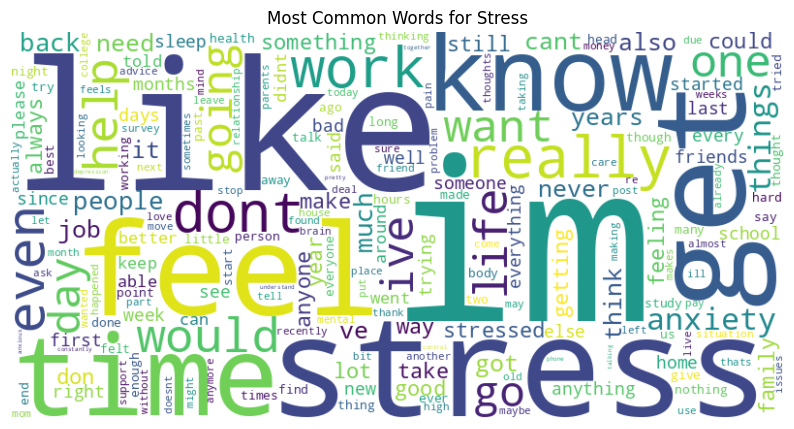

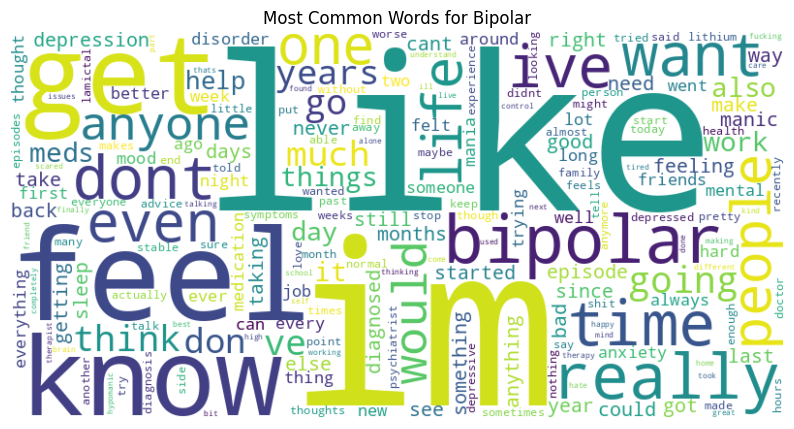

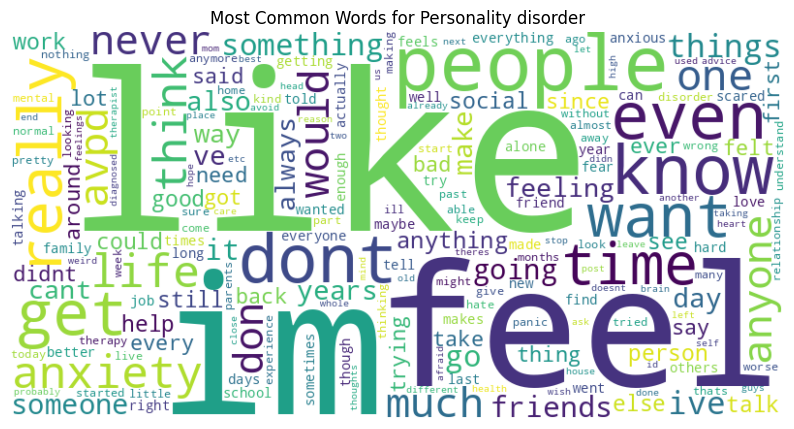

In [20]:
from wordcloud import WordCloud

# Plotting the most common words for each label using bar plots
for label in df['status'].unique():
    plt.figure(figsize=(10, 6))
    common_words = label_word_freq.loc[label].sort_values(ascending=False).head(10)
    sns.barplot(x=common_words.values, y=common_words.index)
    plt.title(f'Most Common Words for {label}')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.show()

# Plotting the most common words for each label using word clouds
for label in df['status'].unique():
    plt.figure(figsize=(10, 6))
    common_words = label_word_freq.loc[label].sort_values(ascending=False)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Common Words for {label}')
    plt.axis('off')
    plt.show()

In [21]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['statement'])
y = df['status']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [23]:
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.4990984151086647
Classification Report:
                       precision    recall  f1-score   support

             Anxiety       0.95      0.09      0.17       755
             Bipolar       0.83      0.02      0.04       527
          Depression       0.37      0.97      0.53      3016
              Normal       0.94      0.60      0.74      3308
Personality disorder       0.00      0.00      0.00       237
              Stress       1.00      0.01      0.01       536
            Suicidal       0.82      0.11      0.19      2158

            accuracy                           0.50     10537
           macro avg       0.70      0.26      0.24     10537
        weighted avg       0.73      0.50      0.44     10537



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
